In [7]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time

import torch 
import torch.nn as nn

device = torch.device("cpu")

class AE(nn.Module):
    def __init__(self, n_comps, n_coeffs):
        super(AE, self).__init__()
        self.n_coeffs = n_coeffs
        self.n_comps = n_comps
        self.D = nn.Linear(1, self.n_comps*404*404, bias=False)
        self.conv1 = nn.Conv2d(self.n_comps, 2*self.n_comps, kernel_size=5, bias=False)
        self.coeffs = nn.Linear(1, 2*self.n_comps*self.n_coeffs, bias=False)
        
    def forward(self, x):
        base = self.D(x)
        conv1 =  torch.tanh(self.conv1(base.reshape(1, self.n_comps, 404, 404)))   
        coeffs = self.coeffs(x).view(2*self.n_comps, self.n_coeffs)
        return torch.einsum('ki,kj->ji', conv1.view(2*self.n_comps,400*400), coeffs)
    
net = torch.load("genoa_net.pt", map_location='cpu')
net.eval()

mean = np.load("genoa_mean.npy").reshape(1,400,400)
print(mean.shape)
out = net(torch.ones(1, device=device)).detach().numpy().reshape(-1,400,400)
print(out.shape)

out += mean

times = np.load("genoa_times.npy")
print(times.shape)

# 3.- Interpolate coeffs to daily values
df = pd.DataFrame(data=np.load("genoa_coeffs.npy").reshape(24*7,-1).T, index=np.load("genoa_times.npy"))
index = pd.date_range('1/1/2018', periods=2*365, freq='D')
df = df.reindex(index, method='nearest', limit=1).interpolate(method='linear', limit_direction='both')
coeffs = df.to_numpy().T

print(coeffs.shape)

(1, 400, 400)
(182, 400, 400)
(26,)
(168, 730)


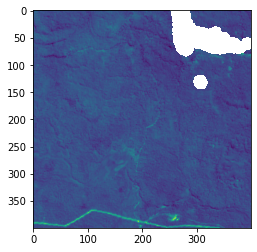

In [8]:
plt.imshow(out[10,:])

In [16]:
import imageio

writer = imageio.get_writer('geroa_falls.mp4', fps=2)

for i in range(26):
    rgb = np.dstack((out[i,:],out[i+26,:],out[i+26*2,:]))
    rgb = (np.clip(rgb*10, a_min=0, a_max=1)*255).astype(np.uint8)
    writer.append_data(rgb)
writer.close()

In [13]:
26*7

182